# Example: Vertical instability (growth rate) calculations

---

This notebook will demonstrate various different ways to calculate the **growth rates** (or **timescales**) associated with **vertically unstable modes** of an equilibrium. We will explore ways to plot these different quantities, carry out eigenmode reduction, and carry out more advanced analysis. 

---

### The deformable growth rate model

Assume we have solved the Grad-Shafranov equation and have obtained an equilibrium. From this we can extract the plasma current density discretised over the spatial domain (whose points are only non-zero inside the LCFS, so we mask points outside the limiter to save memory):

\begin{equation*}
    \bold{I}_y := \bold{I}_y^{GS} (\bold{I}_m, I_p, \bold{\theta}).
    \tag{1}
\end{equation*}

This is a function of the: 
- currents in the metal conductors $\bold{I}_m$ (i.e. the active coils and passive structures).
- plasma current $I_p$.
- parameters $\bold{\theta}$ used to define the plasma current density profiles (i.e. $p'(\psi_n)$ and $FF'(\psi_n)$). 

In order to estimate the instability timescales/growth rates of this plasma, we will need to define (and then linearise) the coupled **circuit** and **plasma** equations. 

**Circuit equations**: 

These equations govern the flow of current in the active coils and passive structures (while being coupled to the currents in the plasma):

\begin{equation}
    M_{m,m} \bold{\dot{I}}_m + M_{m,y} \bold{\dot{I}}_y + R_{m,m} \bold{I}_m = \bold{V}_m
    \tag{2}
\end{equation}

- $M_{m,m}$ is the symmetric matrix of mutual inductances between all of the metals. 
- $M_{m,y}$ is the matrix of mutual inductances between all of the metals and the discretised plasma current density. 
- $R_{m,m}$ is the diagonal matrix of resistances in the metals.
- $V_m$ is the vector of voltages applied to the metals (note: these are non-zero for the active coils only).
- Note that the dots indicate time derivatives. 

**Plasma equation**: 

This equation governs the flow of current in the plasma (while being coupled to the currents in the metals):

\begin{equation}
    \frac{\bold{I}_y^T}{I_p} \left( M_{y,y} \bold{\dot{I}}_y + M_{y,m} \bold{\dot{I}}_m + R_{y,y} \bold{I}_y \right) = \bold{0}
    \tag{3}
\end{equation}

- $M_{y,m} = M_{m,y}^{T}$ (from above).
- $R_{y,y} = 2 \pi \sigma_p \hat{R} /dA$ is the diagonal matrix of resistances for each plasma element.
    - $\sigma_p$ is the assigned plasma resistivity. 
    - $\hat{R}$ is a matrix storing the radial position of each plasma element.
    - $dA$ is the area of each plasma element.


**Linearisation of discretised plasma current density**:

To simplify these equations, we linearise equation (1) around the current GS equilibrium such that:

\begin{equation}
    \dot{\bold{I}_y} \approx \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} \dot{\bold{I}}_m + \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS} \dot{I}_p + \frac{\partial \bold{I}_y}{\partial \bold{\theta}}\Bigg|_{GS} \dot{\bold{\theta}}.
    \tag{4}
\end{equation}

The partial derivative terms (i.e. the Jacobians) are calculated in FreeGSNKE using finite differences. The use of these Jacobians is what makes this a **deformable** growth rate model. 

We can plug this equation into both (2) and (3) and re-arrange:

\begin{align}
    \left( M_{m,m} + M_{m,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} \right) \bold{\dot{I}}_m + M_{m,y} \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS} \dot{I_p} + R_{m,m} \bold{I}_m + M_{m,y} \frac{\partial \bold{I}_y}{\partial \bold{\theta}}\Bigg|_{GS} \dot{\bold{\theta}} = \bold{V}_m \tag{5} \\
    \frac{\bold{I}_y}{I_p} \left[ \left( M_{y,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} + M_{y,m} \right) \dot{\bold{I}}_m  + M_{y,y} \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS} \dot{I_p} + R_{y,y} \bold{I}_y + M_{y,y} \frac{\partial \bold{I}_y}{\partial \bold{\theta}}\Bigg|_{GS} \dot{\bold{\theta}} \right] = \bold{0}. \tag{6}
\end{align}

Next, we need to write this in state matrix form. For this, we need to remove the dependence of equation (6) on the denominator $I_p$ by introducing two terms:
- $\hat{\bold{I}}_y = \bold{I}_y / I_p$ is the normalised discretised plasma current density over the spatial domain.
- $R_p = \hat{\bold{I}}_y^{T} R_{y,y} \hat{\bold{I}}_y$ is the "lumped" plasma resistance.

This results in the state matrix system $\bold{M} \dot{\bold{x}} + \bold{R} \bold{x} = \bold{c}$:

\begin{equation*}
\begin{aligned}
\left[\begin{array}{cc}
 M_{m,m} + M_{m,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} & M_{m,y} \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS} \\ 
\frac{\hat{\bold{I}}_y}{R_p} \left( M_{y,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} + M_{y,m} \right) & \frac{\hat{\bold{I}}_y}{R_p} M_{y,y} \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS}
\end{array}\right]
\left[\begin{array}{c}
\dot{\bold{I}}_m \\ 
\dot{I}_p
\end{array}\right] +

\left[\begin{array}{cc}
R_{m,m} & 0 \\ 
0 & 1
\end{array}\right]
\left[\begin{array}{c}
\bold{I}_m \\ 
I_p
\end{array}\right]

&=
\left[\begin{array}{c}
\bold{V}_m \\ 
0 
\end{array}\right]
-
\left[\begin{array}{c}
M_{m,y} \frac{\partial \bold{I}_y}{\partial \bold{\theta}}\Bigg|_{GS} \dot{\bold{\theta}} \\ 
\frac{\hat{\bold{I}}_y}{R_p} M_{y,y} \frac{\partial \bold{I}_y}{\partial \bold{\theta}}\Bigg|_{GS} \dot{\bold{\theta}}
\end{array}\right].

\end{aligned}
\end{equation*}

Re-arranging, we can write this as 

$$ A\dot{\bold{x}} = \bold{x} - \bold{b}, $$

where $A = -\bold{R}^{-1} \bold{M}$ and $\bold{b} = \bold{R}^{-1} \bold{c}$. 

**Growth rates**:

To ascertain the growth rates of the system, we need to look at the eigenvalues of the system in the absence of any control voltages and change in profile parameters (i.e. $\bold{c}=\bold{0}$). The eigenvalues of $A$, denoted as $\tau_i$, represent the **timescales** of the system (units in seconds). The corresponding eigenvectors $\bold{v}_i$ are the **modes** of the system and represent currents in the metals and the total plasma (the last element).

Therefore:
- $\tau_i > 0$ corresponds to an **unstable** mode $\bold{v}_i$.
- $\tau_i < 0$ corresponds to a **stable** mode $\bold{v}_i$.

These timescales describe the evolution of the plasma vertical instability on the resistive timescale of the conducting metals. Its reciprocal, $\gamma_i = 1/\tau_i$, gives the **growth (or decay) rate** (units in 1/seconds) of a particular mode (decay rate if $\gamma_i < 0$). 

These rates tell us how fast a perturbation in the system grows or decays and later on we will visualise these (eigenmode) perturbations by plotting the poloidal flux they produce in the respective metals.

---

### Basic usage

Here we'll use the same equilibrium as in previous examples, except we've slightly modifed the coil currents to generate a more elongated (vertically unstable) plasma. These coil currents were found by shifting the lower X-point vertically downwards using technqiues from the virtual circuits example notebook.

Active coils --> built from pickle file.
Passive structures --> built from pickle file.
Limiter --> built from pickle file.
Wall --> built from pickle file.
Magnetic probes --> none provided.
Resistance (R) and inductance (M) matrices --> built using actives (and passives if present).
Tokamak built.
Forward static solve SUCCESS. Tolerance 3.73e-10 (vs. requested 1.00e-09) reached in 26/100 iterations.


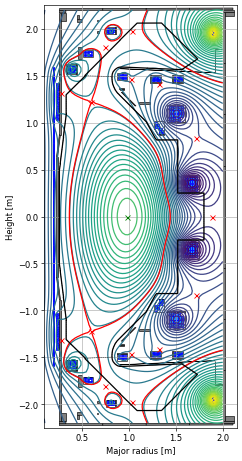

In [1]:
import os
import matplotlib.pyplot as plt
import freegs4e
import numpy as np

# build machine
from freegsnke import build_machine
tokamak = build_machine.tokamak(
    active_coils_path=f"../machine_configs/MAST-U/MAST-U_like_active_coils.pickle",
    passive_coils_path=f"../machine_configs/MAST-U/MAST-U_like_passive_coils.pickle",
    limiter_path=f"../machine_configs/MAST-U/MAST-U_like_limiter.pickle",
    wall_path=f"../machine_configs/MAST-U/MAST-U_like_wall.pickle",
)

# initialise equilibrium object
from freegsnke import equilibrium_update
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  

# initialise profile object
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,
    paxis=8.1e3,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

# initialise solver
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

# set coil currents (these were found using the virtual circuits example)
current_values = {'Solenoid': 5000.0,
 'PX': 4664.8264042905585,
 'D1': 4817.449859117131,
 'D2': 1234.1293690145924,
 'D3': 1369.133338804566,
 'Dp': -905.4445404924389,
 'D5': 3757.2659244120455,
 'D6': -675.5868544077532,
 'D7': -94.84095712236905,
 'P4': -3536.0809826602153,
 'P5': -4568.000388616427,
 'P6': 0.0005793038603228533,
}

for key in current_values.keys():
    eq.tokamak.set_coil_current(coil_label=key, current_value=current_values[key])

# carry out forward solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

# plot the resulting equilbrium
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=60)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

Solving the linearised system requires inititialising the `nl_solver` object. This requires the:
- equilibrium and profiles. 
- plasma resistivity (for the lumped plasma resistance calculation).
- some options regarding mode cut-off frequencies, minimum Jacobian column norms, etc (we will revist these later in the notebook so we can ignore these for now).

Within this object, the Jacobians are calculated and the matrices are built. Depending on the number of active coils and passive structures present in the system, this can take a while (as a GS solve is required for each). Following this, the matrices of the linearised system are used to find the eigenvalues/vectors.

Here we will be using **all** available metal modes, however, later on we will show how to exclude those (via additional options to `nl_solver`) with specific frequencies, timescales, coupling, etc to reduce computational runtime (without losing too much information).

In [2]:
from freegsnke import nonlinear_solve

nonlinear_solver = nonlinear_solve.nl_solver(
    eq=eq, 
    profiles=profiles, 
    GSStaticSolver=GSStaticSolver, 
    plasma_resistivity=1e-6, # this defines the lumped plasma resistances
    min_dIy_dI=0,            # this has been set artificially low in this example
    threshold_dIy_dI=1,      # this has been set artificially high in this example
    max_mode_frequency=1e10  # this has been set artificially high in this example
)

-----
Checking that the provided 'eq' and 'profiles' are a GS solution...
Forward static solve SUCCESS. Tolerance 3.73e-10 (vs. requested 1.00e-08) reached in 0/100 iterations.
-----
Instantiating nonlinear solver objects...
done.
-----
Identifying mode selection criteria...
      'threshold_dIy_dI', 'min_dIy_dI', and 'max_mode_frequency' options selected --> passive structure modes are selected according to these thresholds.
-----
Initial mode selection:
   Active coils
      total selected = 12 (out of 12)
   Passive structures
      138 selected with characteristic timescales larger than 'max_mode_frequency'
      0 recovered that couple with the plasma more than 'threshold_dIy_dI'
      0 removed that couple with the plasma less than 'min_dIy_dI'
      total selected = 138 (out of 138)
   Total number of modes = 150 (12 active coils + 138 passive structures)
      (Note: some additional modes may be removed after Jacobian calculation)
-----
Building the 3051 x 151 Jacobian (dIy/dI)

From the printout we can see the steps being taken.

Once instatiation has taken place, the "mode selection criteria" is chosen based on user inputs - again, we revist this later. This is followed by the "initial mode selection" We see that all active coils (12) and all passive structure modes (138) are included in this case.

Following this, the Jacobian is built. This has dimensions "number of plasma current density points inside the limiter" x "currents included in the analysis". The currents in the analaysis are the active coils (12), the passives (138), and the total plasma current (1) from the plasma equation (total modes being 151). 

After this, any further mode reduction takes place (in this case none) and the Jacobian is re-sized if required. 

The 'Stability parameters' section shows a number of different metrics used to gauge plasma vertical instability. In 'Deformable plasma metrics' we have the growth rate of the unstable mode and the associated timescale (i.e. 1/(growth_rate)). In the 'Rigid plasma metrics' section, we return a number of commonly used parameters that do not make use of the Jacobian matrix (we will discuss these later too).

### Extracting data and visualising

Next, we will show to access some of the calculated data and how to visualise a few things. 

In [3]:
# accessing the number of modes
print(f"Total number of modes excl. plasma current = {nonlinear_solver.n_metal_modes}")   # total (actives + passives)
print(f"Total number of active coils = {nonlinear_solver.n_active_coils}")   # actives
print(f"Total number of passive structures = {nonlinear_solver.n_passive_coils}")   # passives

Total number of modes excl. plasma current = 150
Total number of active coils = 12
Total number of passive structures = 138


In [4]:
# accessing the growth rates (via the timescales)
timescales = nonlinear_solver.linearised_sol.all_timescales # all eigenvalues: timescales
growth_rates = 1/timescales                                 # growth rates are simply 1/timescales
modes = nonlinear_solver.linearised_sol.all_modes           # all eigenvectors (columns in same order as e'values)

In [5]:
# extracting the unstable mode
mask = (timescales > 0)
idx = np.where(mask)[0][0] # index of unstable mode
unstable_timescales = timescales[mask]
unstable_modes = np.squeeze(modes[:,mask])

We can visualise the poloidal flux produced by the unstable mode using the following code. We can also do this for other (stable) modes if required (just change the index `i` in the cell below).

Mode 19 ---> unstable
Growth rate = 2.77e+02 [1/s]
Timescale = 3.61e-03 [s]


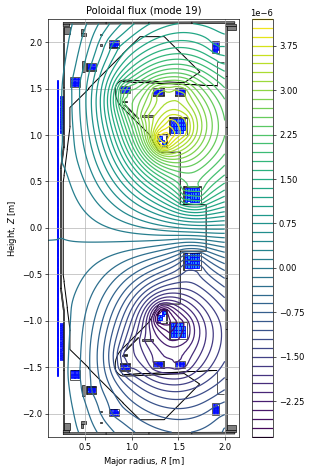

In [6]:
# mode number (choose which one you want to visualise)
i = idx # default is unstable mode
mode_currents = np.real(modes[:,i])

# the associated instability timescale and growth rate
print(f"Mode {i} ---> {'stable' if np.real(timescales[i]) < 0 else 'unstable'}")
print(f"Growth rate = {np.real(growth_rates[i]):.2e} [1/s]")
print(f"Timescale = {np.real(timescales[i]):.2e} [s]")

# multiply each metal current (from the eigenvector) with its corresponding Greens matrix and sum
# (don't forget to omit the plasma current mode, i.e. the final element)
flux = np.sum(mode_currents[0:-1, np.newaxis, np.newaxis] * nonlinear_solver.vessel_modes_greens, axis=0)

# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 8), dpi=60)
ax.grid(True, which='both')
ax.set_aspect('equal')
ax.set_xlim(0.1, 2.15)
ax.set_ylim(-2.25, 2.25)
ax.set_title(f"Poloidal flux (mode {i})")
ax.set_xlabel(r'Major radius, $R$ [m]')
ax.set_ylabel(r'Height, $Z$ [m]')
plt.tight_layout()

eq.tokamak.plot(axis=ax,show=False)
ax.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im = ax.contour(eq.R, eq.Z, flux, levels=50)                        
cbar = plt.colorbar(im, ax=ax, fraction=0.09)

Next, we can extract two different plasma current density $J_{p}(\psi, R,Z)$ maps: call them $J_{p}^{deform}$ and $J_{p}^{rigid}$.

The first corresponds to an application of the unstable mode currents to the equilbirium, solving the GS equation, and observing the "deformable" movement of the plasma core (it shifts in $(R,Z)$ and also the boundary will displace). This results in a new current density map $J_{p}^{deform}$. 

The second corresponds to taking the $(R,Z)$ shifts in the current centre (from $J_{p}^{deform}$) and shifting the $J_p$ map from the orginal equilibrium. In this case we observe a "rigid" displacement of the plasma current density: $J_{p}^{rigid}$. 

While they do not look significantly different in the case presented here, they will when studying more vertically unstable plasmas. Below we plot the boundaries of these two Jtor maps (left) and the difference between the full maps (right). 

Rate of change of Rcurrent wrt unstable mode = 2.04e-06 [m].
Rate of change of Zcurrent wrt unstable mode = 1.22e-05 [m].


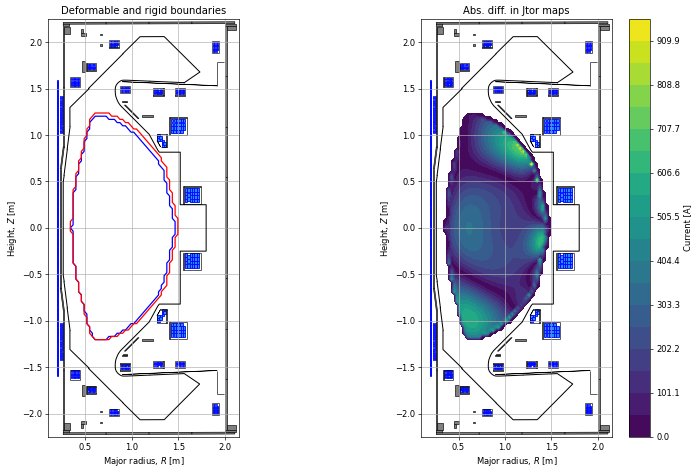

In [7]:
# data
jtor_maps = nonlinear_solver.deformable_vs_rigid_jtor  

# rate of change of R and Z current centre of plasma wrt to the unstable mode only
dRZd_unstable_mode = nonlinear_solver.dRZd_unstable_mode
print(f"Rate of change of Rcurrent wrt unstable mode = {dRZd_unstable_mode[0]:.2e} [m].")
print(f"Rate of change of Zcurrent wrt unstable mode = {dRZd_unstable_mode[1]:.2e} [m].")

diff = np.abs(jtor_maps[0] - jtor_maps[1])

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), dpi=60)

ax1.grid(True, which='both')
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(f"Deformable and rigid boundaries")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
plt.tight_layout()

eq.tokamak.plot(axis=ax1,show=False)
ax1.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
ax1.contour(eq.R, eq.Z, jtor_maps[0], levels=[0], colors='b')        
ax1.contour(eq.R, eq.Z, jtor_maps[1], levels=[0], colors='r')  


ax2.grid(True, which='both')
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(f"Abs. diff. in Jtor maps")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')

eq.tokamak.plot(axis=ax2,show=False)
ax2.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contourf(eq.R, eq.Z, diff, levels=np.linspace(0.01, np.max(diff), 20))
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)
cbar.set_label('Current [A]')

# could plot difference

In the next plot, we show how to visualise the derivative of the plasma current density with respect to the metal currents (i.e. visualise the finite difference calculated Jacobian). Given we have used all the modes, the index `i` will correspond to the metal given in `eq.tokamak.coils_list[i]`.

As before, just choose a mode number and plot.

Jacobian for metal: P6


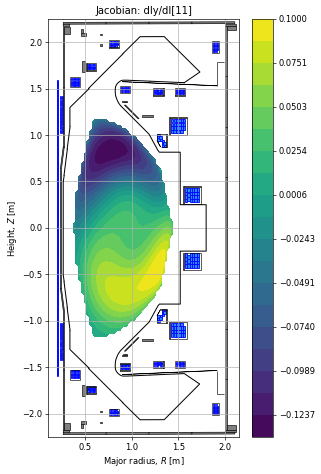

In [28]:
# extract the Jacobian (no. plasma current points x no. modes) 
# i.e. the full finite-difference Jacobian of plasma current density points wrt metal currents 
dIydI = nonlinear_solver.dIydI       

# choose the mode number you want to plot
i = 11

if i < 150:
    print(f"Jacobian for metal: {eq.tokamak.coils_list[i]}")
else:
    print(f"Jacobian for plasma current")

# extracts the column of the Jacobian and places into the correct grid for plotting
derivs = np.full(nonlinear_solver.limiter_handler.mask_inside_limiter.shape, np.nan)
derivs[nonlinear_solver.limiter_handler.mask_inside_limiter] = dIydI[:,i]
derivs[derivs == 0] = np.nan # any values exactly zero should be outside LCFS

# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 8), dpi=60)
ax.grid(True, which='both')
ax.set_aspect('equal')
ax.set_xlim(0.1, 2.15)
ax.set_ylim(-2.25, 2.25)
ax.set_title(f"Jacobian: dIy/dI[{i}]")
ax.set_xlabel(r'Major radius, $R$ [m]')
ax.set_ylabel(r'Height, $Z$ [m]')
plt.tight_layout()

eq.tokamak.plot(axis=ax,show=False)
ax.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im = ax.contourf(eq.R, eq.Z, derivs, levels=np.linspace(np.nanmin(derivs), np.nanmax(derivs), 20))                  
cbar = plt.colorbar(im, ax=ax, fraction=0.09)

### Stability parameters

We now revisit the 'Stability parameters' that were returned when we instantiated the `nl_solver` object. 

In addition to the deformable growth rate, we can extract other commonly used stability metrics (some that assume a deformable plasma and some that assume a rigid non-deformable plasma).

#### Inductive stability margin parameter

The first is the inductive stability margin parameter given by equation (4) of [Humphreys et al. (2009)](https://dx.doi.org/10.1088/0029-5515/49/11/115003) and first proposed by [Portone (2005)](https://iopscience.iop.org/article/10.1088/0029-5515/45/8/021).

This parameter quantifies the ability of the active coil system to stabilise vertical displacements of the plasma. It is purely inductive as it does not contain any resistance terms and is given by

$$ m_s := \lambda \left[ -M_{m,m}^{-1} \left( M_{m,m} + M_{m,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} \right) \right], $$

where the operator $\lambda[A]$ returns the largest non-negative eigenvalue of the matrix $A$. This is the counterpart to the "resistive" stability margin (i.e. the deformable timescale) that is described in the "Removing the plasma equation" - where in this case the plasma equation has been omitted (i.e. $\dot{I_p} = 0$).

Different tokamaks have different minimum values of $m_s$ that plasmas need to remain above in order for them to be vertically controllable. Note that this parameter makes use of the Jacobian and is therefore affected by any eigenmode reduction (see below) that takes place. 

In [9]:
print(f"Inductive stability margin = {nonlinear_solver.linearised_sol.stability_margin}")

Inductive stability margin = [0.38349804+0.j]


#### Leuer parameter

The second is the stability parameter outlined in equation (6) of [Leuer (1989)](https://www.tandfonline.com/doi/abs/10.13182/FST89-A39747). See the reference for more details on its interpretation.

The (generalised) Leuer stability parameter is defined as the ratio of stabilising force gradient to de-stabilising force gradient acting on the system:

\begin{equation}
    f := \frac{f_{stab}}{f_{destab}} = \frac{\bold{I}_y^T M'_{y,m} M^{-1}_{m,m} M'_{m,y} \bold{I}_y}{\bold{I}_y^T M''_{y,m} \bold{I}_m},
\end{equation}

where $M'$ and $M''$ denote the first and second derivatives of the mutual inductances with respect to the $Z$ coordinate, respectively. Other matrices are defined as they are above. We can find these derivatives using the relations:

\begin{align}
    \frac{d}{dZ} M_{y,m} = \frac{d}{dZ} M (R_y, Z_y ; R_m, Z_m) &= \frac{d}{dZ} 2 \pi G (R_y, Z_y ; R_m, Z_m) \\
    &= \frac{d}{dZ} 2 \pi \psi (R_y, Z_y ; R_m, Z_m) \\
    &= - 2 \pi R_m B_R (R_y, Z_y ; R_m, Z_m). 
\end{align}

Here, $G$ is the Greens function between the plasma locations and the metal locations (which is equal to the poloidal flux $\psi_{y,m}$ at the metal locations produced by a unit current at the plasma locations). We can then use the relation $B_R = - (d \psi / dZ) / R$, where $B_R$ is the radial magnetic field. Note the actual calculation of this is slightly more involed when the metals are defined using filaments (see source code in nonlinear_solve.py).

The second derivative is similar except we need $d B_R/ dZ$ instead of $B_R$. 

This stability parameter can be calculated in different ways by choosing which metals ($m$) to include in the calculation. Note, however, that no mode decomposition (see below) is performed when calculating these metrics. 

Also note that in this particular equilibrium the metrics look very similar because there are no currents in the passive structures!

In [10]:
print(f"Stabilisation force gradient (from all metals) = {nonlinear_solver.all_coils_stab_force}")
print(f"Stabilisation force gradient (from active coils) = {nonlinear_solver.actives_stab_force}")
print(f"Stabilisation force gradient (from passive coils) = {nonlinear_solver.passives_stab_force}")
print("---")
print(f"De-stabilisation force gradient (from all metals) = {nonlinear_solver.all_coils_destab_force}")
print(f"De-tabilisation force gradient (from active coils) = {nonlinear_solver.actives_destab_force}")
print(f"De-tabilisation force gradient (from passive coils) = {nonlinear_solver.passives_destab_force}")
print("---")
print(f"Leuer parameter (passives over actives) = {nonlinear_solver.passives_stab_force/nonlinear_solver.actives_destab_force}")
print(f"Leuer parameter (all metals over actives) = {nonlinear_solver.all_coils_stab_force/nonlinear_solver.actives_destab_force}")
print(f"Leuer parameter (all metals over all metals) = {nonlinear_solver.all_coils_stab_force/nonlinear_solver.all_coils_destab_force}")

Stabilisation force gradient (from all metals) = 153202.78385696805
Stabilisation force gradient (from active coils) = 88017.72513954167
Stabilisation force gradient (from passive coils) = 153201.45997636003
---
De-stabilisation force gradient (from all metals) = 104708.18929601288
De-tabilisation force gradient (from active coils) = 104708.18929601288
De-tabilisation force gradient (from passive coils) = 0.0
---
Leuer parameter (passives over actives) = 1.4631277744977078
Leuer parameter (all metals over actives) = 1.4631404180226977
Leuer parameter (all metals over all metals) = 1.4631404180226977


### Back to the deformable model: Removing the plasma equation

The deformable growth rates can also be computed in the case where we assume $\bold{\dot{I}}_p = 0$. For this, the final row/column of the state space matrices above are omitted and the system becomes:

\begin{equation*}
    \left( M_{m,m} + M_{m,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} \right) \dot{\bold{I}}_m + R_{m,m} \bold{I}_m = \bold{V}_m - M_{m,y} \frac{\partial \bold{I}_y}{\partial \bold{\theta}}\Bigg|_{GS} \dot{\bold{\theta}},
\end{equation*}

and we find the eigenvaluesas before. 

This may be useful, for example, if you do not have a good intuition for what the `plasma_resistivity` parameter (in the `nl_solver` object) is. Recall that this goes into the "lumped" plasma equation and therefore the state space matrices when calculating the growth rates.

To extract these timescales and modes, simply call the following and carry out your analysis as desired:

In [11]:
# accessing the growth rates (via the timescales)
timescales_const_Ip = nonlinear_solver.linearised_sol.all_timescales_const_Ip # all eigenvalues: timescales (descending order) without plasma equation
growth_rates_const_Ip = 1/timescales_const_Ip                                 # all eigenvalues: growth rates (descending order) without plasma equation
modes_const_Ip = nonlinear_solver.linearised_sol.all_modes_const_Ip           # all eigenvectors (columns in same order as e'values) without plasma equation

### Mode decomposition

The initial calculation of the growth rates was quite lengthy because we included all of the passive structures (each of which requires a GS solve to calculate the Jacobian matrix).

In such cases where lots of passive structures are present in a tokamak, it is possible to carry out **mode decomposiiton**. This is the process by which we can exclude a number of passive structure modes that couple weakly with the plasma (thereby having a small impact on the instability timescale) and save some compute time. 

There are, however, a number of different ways to choose the subset of passive structure modes. These are outlined in the "Options" below. 

Before we show how to do this computationally, we outline the modifications to the original state space matrix system above in order to acheive this. Further details can be found in [Appendix 2 of Amorisco et al. (2024)](https://pubs.aip.org/aip/pop/article/31/4/042517/3286904/FreeGSNKE-A-Python-based-dynamic-free-boundary).b

#### How the decomposition works

To carry out the decomposition, we start by identifying the eigenvalues/vectors (characteristic frequencies and modes) of the passive structure system. We do this by diagonalising $R_{pas,pas}^{-1} M_{pas,pas}$:

\begin{equation*}
    R_{pas,pas}^{-1} M_{pas,pas} = P_{pas,pas} \Lambda_{pas,pas} P_{pas,pas}^{-1},
\end{equation*}

where $\Lambda_{pas,pas}$ is the diagonal matrix of eigenvlaues and $P_{pas,pas}$ is the matrix of eigenvectors (columns). We can use this matrix to define the block diagonal change of basis matrix:

\begin{equation*}
    P := \left[\begin{array}{cc}
        \mathcal{I}_{act,act} & 0 \\ 
        0 & P_{pas,pas}
        \end{array}\right],
\end{equation*}
where $\mathcal{I}_{act,act}$ is the identity matrix (with size equal to number of active coils). Supposing we retain $k$ columns of $P$ (including all of the active coils and a subset of the "most strongly coupled" passive structures), we can write the full vector of metal currents as 
\begin{equation*}
    \bold{I}_m = P \bold{I}_d,
\end{equation*}
where $\bold{I}_d$ is the "reduced" set of $k$ mode currents.

Now, recall the state space matrix system from above. If we apply our expression for $\bold{I}_m$, we get:

\begin{equation*}
\begin{aligned}
\left[\begin{array}{cc}
 M_{m,m}P + M_{m,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS}P & M_{m,y} \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS} \\ 
\frac{\hat{\bold{I}}_y}{R_p} \left( M_{y,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS}P + M_{y,m}P \right) & \frac{\hat{\bold{I}}_y}{R_p} M_{y,y} \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS}
\end{array}\right]
\left[\begin{array}{c}
\dot{\bold{I}}_d \\ 
\dot{I}_p
\end{array}\right] +

\left[\begin{array}{cc}
R_{m,m}P & 0 \\ 
0 & 1
\end{array}\right]
\left[\begin{array}{c}
\bold{I}_d \\ 
I_p
\end{array}\right]

&=
\left[\begin{array}{c}
\bold{V}_m \\ 
0 
\end{array}\right]
-
\left[\begin{array}{c}
M_{m,y} \frac{\partial \bold{I}_y}{\partial \bold{\theta}}\Bigg|_{GS} \dot{\bold{\theta}} \\ 
\frac{\hat{\bold{I}}_y}{R_p} M_{y,y} \frac{\partial \bold{I}_y}{\partial \bold{\theta}}\Bigg|_{GS} \dot{\bold{\theta}}
\end{array}\right].

\end{aligned}
\end{equation*}

We end up with some modified matrices, which we can use in the same way to calculate the $k$ reduced timescales/modes. This reduces computational runtime for the Jacobian calculation as well as we are no longer calculating for all metals but a subset $k$. Note that during a linear evolutive solve (recall example notebook 5), these are the equations that will be used to evolve the mode currents (and plasma current). 

Next we show a few different ways to select the "most strongly" coupled passive structure modes. 

#### Option 1: Fixing the number of passive structure modes explicity

While the active coils will always be included as modes, you can set the number of passive structure modes directly via the `fix_n_vessel_modes` option (choose a number between 0 and the number of passive structures in the tokamak object).

The process by which the passive modes are chosen is as follows:
1. A first "estimate" of
   $$
   \lambda_i = \left\| \left( \frac{\partial \mathbf{I}_y}{\partial \mathbf{I}_m} \right)_{:,i} \right\|,
   $$
   is calculated for all passive structure modes (without fully solving the GS equation and calculating the true Jacobian). This is done by perturbing the currents in the modes (passive structures), updating the poloidal flux produced by these currents, and then evaluating the plasma current density $J_p(R,Z, \psi)$ to obtain the perturbed $\mathbf{I}_y$. Here, $\psi$ is the total poloidal flux, i.e. the plasma and the metals contributions combined.

2. The $\lambda_i$ are then sorted into ascending order and with $\hat{\lambda} = \max_i \{ \lambda_i\}$ being the largest (strongest coupling).

3. The top (strongest coupled) `fix_n_vessel_modes` are then selected for inclusion in the mode decomposition. 

As one might expect, increasing `fix_n_vessel_modes` will increase the timescale of the unstable mode (which in turn leads to a smaller unstable growth rate).

In [12]:
# instantiate the nl_solver object with fixed mode
nonlinear_solver_option_1 = nonlinear_solve.nl_solver(
    eq=eq, 
    profiles=profiles, 
    GSStaticSolver=GSStaticSolver, 
    plasma_resistivity=1e-6,
    fix_n_vessel_modes=50,
)

-----
Checking that the provided 'eq' and 'profiles' are a GS solution...
Forward static solve SUCCESS. Tolerance 3.73e-10 (vs. requested 1.00e-08) reached in 0/100 iterations.
-----
Instantiating nonlinear solver objects...
done.
-----
Identifying mode selection criteria...
      'fix_n_vessel_modes' option selected --> passive structure modes that couple most to the strongest passive structure mode are being selected.
-----
Initial mode selection:
   Active coils
      total selected = 12 (out of 12)
   Passive structures
      50 selected using 'fix_n_vessel_modes'
   Total number of modes = 62 (12 active coils + 50 passive structures)
      (Note: some additional modes may be removed after Jacobian calculation if 'mode_removal=True')
-----
Building the 3051 x 63 Jacobian (dIy/dI) of plasma current density (inside the LCFS) with respect to all metal currents and the total plasma current.
-----
Stability paramters:
   Deformable plasma metrics:
      Growth rate = [285.64565005+0.j] 

Again, we can plot how these look using similar code as before, except we need to remember that now we've done a mode decomposition, the eigenmode currents $\bold{I}_d$ need to be transformed back into the original metal currents $\bold{I}_m$. This is done in the plotting cell below.

In [13]:
# accessing the growth rates (via the timescales)
timescales = nonlinear_solver_option_1.linearised_sol.all_timescales  # all eigenvalues: timescales
growth_rates = 1/timescales                                           # growth rates are simply 1/timescales
modes = nonlinear_solver_option_1.linearised_sol.all_modes             # all eigenvectors (columns in same order as e'values)

In [14]:
# extracting the unstable mode
mask = (timescales > 0)
idx = np.where(mask)[0][0] # index of unstable mode
unstable_timescales = timescales[mask]
unstable_modes = np.squeeze(modes[:,mask])

In [25]:
# mode number (choose which one you want to visualise)
# note now that there are only 63 modes instead of 151
i = idx   # unstable mode
# i = 0 to 62 (all modes)

# this function transforms the (decomposed) mode currents back to regular metal currents
# (don't forget to omit the plasma current mode, i.e. the final element)
mode_currents = nonlinear_solver_option_1.evol_metal_curr.IdtoIvessel(np.real(modes[0:-1,i]))

# the associated instability timescale and growth rate
print(f"Mode {i} ---> {'stable' if np.real(timescales[i]) < 0 else 'unstable'}")
print(f"Growth rate = {np.real(growth_rates[i]):.2e} [1/s]")
print(f"Timescale = {np.real(timescales[i]):.2e} [s]")

# multiply each metal current (from the eigenvector) with its corresponding Greens matrix and sum
flux = np.sum(mode_currents[:, np.newaxis, np.newaxis] * nonlinear_solver_option_1.vessel_modes_greens, axis=0)

# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 8), dpi=60)
ax.grid(True, which='both')
ax.set_aspect('equal')
ax.set_xlim(0.1, 2.15)
ax.set_ylim(-2.25, 2.25)
ax.set_title(f"Poloidal flux (mode {i})")
ax.set_xlabel(r'Major radius, $R$ [m]')
ax.set_ylabel(r'Height, $Z$ [m]')
plt.tight_layout()

eq.tokamak.plot(axis=ax,show=False)
ax.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im = ax.contour(eq.R, eq.Z, flux, levels=50)                        
cbar = plt.colorbar(im, ax=ax, fraction=0.09)

IndexError: list index out of range

#### Option 2: Choosing modes based on coupling and mode frequency

Alternatively, one can be more precise and select modes based on how well they couple to the "strongest" mode (via `min_dIy_dI` and `threshold_dIy_dI`) and whether they are below some maximum mode frequency (via `max_mode_frequency`). To explain how this works, we define these parameters as follows: 
- $\alpha=$ `min_dIy_dI` $\in [0,1]$.
- $\beta=$`threshold_dIy_dI` $\in [0,1]$ (note that $\alpha \leq \beta$).
- $\omega=$`max_mode_frequency` $\geq 0$.

The approximate process to select the modes is as follows:

1. Order the eigenvalues (characteristic frequencies) of  
   $$
   R_{pas,pas}^{-1} M_{pas,pas},
   $$  
   in ascending order and flag any above $\omega$ for removal. Here $R$ and $M$ are the resistance and inductance matrices for the passive structure metals only.

2. As in option 1, calculate a first estimate of  
   $$
   \lambda_i = \left\| \left( \frac{\partial \mathbf{I}_y}{\partial \mathbf{I}_m} \right)_{:,i} \right\|
   $$  
   for all passive structure modes without fully solving the GS equation for each (this is done for flagged modes too). This is prior to the full Jacobian calculation later on.

3. Define the "strongest" coupled passive structure mode as $\hat{\lambda} = \max_i \{ \lambda_i\}$ and then keep any modes where
   $$
   \beta \hat{\lambda} \leq \lambda_i,
   $$
   even if they had previously been flagged for removal. 

4. Remove any modes where
   $$
   \lambda_i \leq \alpha \hat{\lambda},
   $$
   regardless of whether they were flagged or not.

5. Any remaining modes that had been flagged and not yet removed or kept are then removed.

6. For the remaining modes, the "true" finite-difference Jacobian is calculated and if `mode_removal=True`, any extra modes with their "true" $\lambda_i \leq \alpha \hat{\lambda}$ are also removed. 

These selected modes are then used in the mode decomposition. 

The following diagram should further explain which modes are removed in the coupling-frequency space. 

![Mode selection diagram](data/mode_selection.jpg)


An example of how to do this follows. The print out tells you which modes are selected and which are removed at each stage of the process.

In [16]:
# instantiate the nl_solver object with option 2 parameters
nonlinear_solver_option_2 = nonlinear_solve.nl_solver(
    eq=eq, 
    profiles=profiles, 
    GSStaticSolver=GSStaticSolver, 
    min_dIy_dI=0.15,        
    threshold_dIy_dI=0.5,
    max_mode_frequency=1e3, 
)

-----
Checking that the provided 'eq' and 'profiles' are a GS solution...
Forward static solve SUCCESS. Tolerance 3.73e-10 (vs. requested 1.00e-08) reached in 0/100 iterations.
-----
Instantiating nonlinear solver objects...
done.
-----
Identifying mode selection criteria...
      'threshold_dIy_dI', 'min_dIy_dI', and 'max_mode_frequency' options selected --> passive structure modes are selected according to these thresholds.
-----
Initial mode selection:
   Active coils
      total selected = 12 (out of 12)
   Passive structures
      38 selected with characteristic timescales larger than 'max_mode_frequency'
      0 recovered that couple with the plasma more than 'threshold_dIy_dI'
      33 removed that couple with the plasma less than 'min_dIy_dI'
      total selected = 5 (out of 138)
   Total number of modes = 17 (12 active coils + 5 passive structures)
      (Note: some additional modes may be removed after Jacobian calculation)
-----
Building the 3051 x 18 Jacobian (dIy/dI) of pl

We should note that in cases where too few modes are retained, the solver will return a message saying that the plasma is either **stable** or it is **Alfven unstable**. In the example below, we set `fix_n_vessel_modes` to zero, demonstrating what happens without any passive stabilisation. 

In [17]:
# instantiate the nl_solver object with option 1 parameters
nonlinear_solver_option_3 = nonlinear_solve.nl_solver(
    eq=eq, 
    profiles=profiles, 
    GSStaticSolver=GSStaticSolver, 
    fix_n_vessel_modes=0, 
)

-----
Checking that the provided 'eq' and 'profiles' are a GS solution...
Forward static solve SUCCESS. Tolerance 3.73e-10 (vs. requested 1.00e-08) reached in 0/100 iterations.
-----
Instantiating nonlinear solver objects...
done.
-----
Identifying mode selection criteria...
      'fix_n_vessel_modes' option selected --> passive structure modes that couple most to the strongest passive structure mode are being selected.
-----
Initial mode selection:
   Active coils
      total selected = 12 (out of 12)
   Passive structures
      0 selected using 'fix_n_vessel_modes'
   Total number of modes = 12 (12 active coils + 0 passive structures)
      (Note: some additional modes may be removed after Jacobian calculation if 'mode_removal=True')
-----
Building the 3051 x 13 Jacobian (dIy/dI) of plasma current density (inside the LCFS) with respect to all metal currents and the total plasma current.
-----
Stability paramters:
      No unstable modes found: either plasma stable, or more likely, it

### Other useful optional parameters

There are a number of additional optional parameters that can be selected when initialising the `nl_solver` object:
- The user can choose to specify custom metal resistances (vector) and inductances (matrix) via `custom_coil_resist` and `custom_self_ind` (just ensure dimensions match the number of active and passive coils you have). 
- If you already calculated the Jacobian in a previous instatiation of the object, you can provide it via `dIydI` to save calculating it again. 
- The timestep for evolutive simulations can be set via `full_timestep` and the internal timesteps within this full one can be set with `max_internal_timestep`. If, however, `automatic_timestep` is set (as a tuple of two floats), these values are overwritten such that `full_timestep` will equal automatic_timestep[0]*unstable_mode_timescale and `max_internal_timestep` will equal automatic_timestep[1]*unstable_mode_timescale.
- By setting `force_core_mask_linearization` to True, you can ensure that the finite difference calculations for the Jacobian are based on plasmas that have the same core region as each other.

### More advanced study: moving coils/passives

Often of interest is to observe what happens to the growth rate parameters as you physically move an active coil or a passive structure. This can be useful for the design of new tokamaks. 

Here, we build a toy tokamak with three pairs of up-down symmetric active coils (P1 and P2 are connected in series, while P3 is connected in anti-series). Coils connected in anti-series are typically used for vertical control of the plasma. We will start by solving for an equilibrium and showing what it looks like. 

In [18]:
# define the active coils 
active_coils = {'P1': {'1': {'R': [0.7],
   'Z': [-0.8],
   'dR': 0.05,
   'dZ': 0.05,
   'resistivity': 1.55e-08,
   'polarity': 1.0,
   'multiplier': 1.0},
  '2': {'R': [0.7],
   'Z': [0.8],
   'dR': 0.05,
   'dZ': 0.05,
   'resistivity': 1.55e-08,
   'polarity': 1.0,
   'multiplier': 1.0}},
 'P2': {'1': {'R': [1.75],
   'Z': [-0.6],
   'dR': 0.05,
   'dZ': 0.05,
   'resistivity': 1.55e-08,
   'polarity': 1.0,
   'multiplier': 1.0},
  '2': {'R': [1.75],
   'Z': [0.6],
   'dR': 0.05,
   'dZ': 0.05,
   'resistivity': 1.55e-08,
   'polarity': 1.0,
   'multiplier': 1.0}},
 'P3': {'1': {'R': [1.5],
   'Z': [-0.5145],
   'dR': 0.05,
   'dZ': 0.05,
   'resistivity': 1.55e-08,
   'polarity': 1.0,
   'multiplier': 1.0},
  '2': {'R': [1.5],
   'Z': [0.5145],
   'dR': 0.05,
   'dZ': 0.05,
   'resistivity': 1.55e-08,
   'polarity': -1.0,
   'multiplier': 1.0}}}

# define a pair of symmetric passive structures (these will have limited effect on the plasma)
passives = []
passives.append({
    "R": [1.81,1.81,1.79,1.79],
    "Z": [0.51,0.49,0.49,0.51],
    "name": 'passive_lower_wall',
    "resistivity": 5.5e-7
})
passives.append({
    "R": [1.81,1.81,1.79,1.79],
    "Z": [-0.51,-0.49,-0.49,-0.51],
    "name": 'passive_upper_wall',
    "resistivity": 5.5e-7
})

# define a rectangular limiter to contain the plasma
limiter = [{'R': 0.5, 'Z': -1}, {'R': 0.5, 'Z': 1}, {'R': 2, 'Z': 1}, {'R': 2, 'Z': -1}, {'R': 0.5, 'Z': -1}]

Active coils --> built from user-provided data.
Passive structures --> none provided.
Limiter --> built from user-provided data.
Wall --> built from user-provided data.
Magnetic probes --> none provided.
Resistance (R) and inductance (M) matrices --> built using actives (and passives if present).
Tokamak built.


Forward static solve SUCCESS. Tolerance 2.97e-11 (vs. requested 1.00e-10) reached in 37/100 iterations.


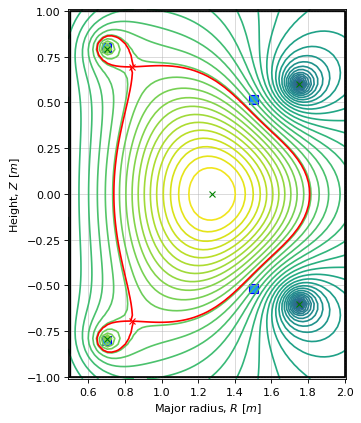

In [19]:
# build machine
tokamak_toy = build_machine.tokamak(
    active_coils_data=active_coils,
    limiter_data=limiter,
    wall_data=limiter,
)

# build equilibrium object
eq_toy = equilibrium_update.Equilibrium(
    tokamak=tokamak_toy,
    Rmin=.49, Rmax=2.01,   # Radial range
    Zmin=-1.01, Zmax=1.01,  # Vertical range
    nx=65,   # Number of grid points in the radial direction
    ny=65,  # Number of grid points in the vertical direction
)

# initialise Jtor profile object (here we use the Lao profiles) 
from freegsnke.jtor_update import Lao85
profiles_toy = Lao85(
    eq=eq_toy,
    Ip=2e5,
    fvac=0.5,
    alpha=[58213.6],
    beta=[0.582136]
)

# assign some currents to coils 
eq_toy.tokamak.set_coil_current(coil_label="P1", current_value=58550)
eq_toy.tokamak.set_coil_current(coil_label="P2", current_value=-51640)
eq_toy.tokamak.set_coil_current(coil_label="P3", current_value=0)

# load static GS solver
GSStaticSolver_toy = GSstaticsolver.NKGSsolver(eq_toy)    

# solve for equilibrium
GSStaticSolver_toy.forward_solve(
    eq=eq_toy, 
    profiles=profiles_toy, 
    target_relative_tolerance=1e-10
    )

# plot equilibrium
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6), dpi=80)
ax1.grid(zorder=0, alpha=0.5)
eq_toy.plot(axis=ax1,show=False)
tokamak_toy.plot(axis=ax1, show=False)
ax1.fill(tokamak_toy.wall.R, tokamak_toy.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax1.set_aspect('equal')
ax1.set_xlabel(r'Major radius, $R$ $[m]$')
ax1.set_ylabel(r'Height, $Z$ $[m]$')
plt.show()

We can see that we have a highly-deformed plasma sitting between (but close to) the vertical stability coils. We will now see what happens to the instability timescales (and the equilbiria themselves) when we move these coils vertically away from the plasma. 

In [20]:
from copy import deepcopy 

# storage lists
abs_P3_position = []
timescales = []
leuer = []
eqs = []

# do this for ten shifts in position
for i in range(0,10):

    # modify P3 coil Z position
    active_coils['P3']['1']['Z'][0] -= 0.075   # move down 7.5cm
    active_coils['P3']['2']['Z'][0] += 0.075   # move up 7.5cm

    # build machine
    tokamak_toy = build_machine.tokamak(
        active_coils_data=active_coils,
        # passive_coils_data=passives,
        limiter_data=limiter,
        wall_data=limiter,
    )

    # build equilibrium object
    eq_toy = equilibrium_update.Equilibrium(
        tokamak=tokamak_toy,
        Rmin=.49, Rmax=2.01,   # Radial range
        Zmin=-1.01, Zmax=1.01,  # Vertical range
        nx=65,   # Number of grid points in the radial direction
        ny=65,  # Number of grid points in the vertical direction
    )

    # initialise Jtor profile object (here we use the Lao profiles) 
    profiles_toy = Lao85(
        eq=eq_toy,
        Ip=2e5,
        fvac=0.5,
        alpha=[58213.6],
        beta=[0.582136]
    )

    # assign currents to coils 
    eq_toy.tokamak.set_coil_current(coil_label="P1", current_value=58550)
    eq_toy.tokamak.set_coil_current(coil_label="P2", current_value=-51640)
    eq_toy.tokamak.set_coil_current(coil_label="P3", current_value=0)

    # load static GS solver
    GSStaticSolver_toy = GSstaticsolver.NKGSsolver(eq_toy)    

    # solve for equilibrium
    GSStaticSolver_toy.forward_solve(
        eq=eq_toy, 
        profiles=profiles_toy, 
        target_relative_tolerance=1e-10
        )

    # calculate the instability timescale 
    nonlinear_solver_toy = nonlinear_solve.nl_solver(
        eq=eq_toy, 
        profiles=profiles_toy,
        GSStaticSolver=GSStaticSolver_toy, 
        fix_n_vessel_modes=0,
    )

    # store data
    abs_P3_position.append(active_coils['P3']['2']['Z'][0])
    timescales.append(nonlinear_solver_toy.linearised_sol.all_timescales)
    leuer.append(nonlinear_solver_toy.linearised_sol.all_timescales)
    eqs.append(deepcopy(eq_toy))


Active coils --> built from user-provided data.
Passive structures --> none provided.
Limiter --> built from user-provided data.
Wall --> built from user-provided data.
Magnetic probes --> none provided.
Resistance (R) and inductance (M) matrices --> built using actives (and passives if present).
Tokamak built.
Forward static solve SUCCESS. Tolerance 2.97e-11 (vs. requested 1.00e-10) reached in 37/100 iterations.
-----
Checking that the provided 'eq' and 'profiles' are a GS solution...
Forward static solve SUCCESS. Tolerance 2.97e-11 (vs. requested 1.00e-08) reached in 0/100 iterations.
-----
Instantiating nonlinear solver objects...
done.
-----
Identifying mode selection criteria...
      no passive modes present!
-----
Initial mode selection:
   Active coils
      total selected = 3 (out of 3)
   Passive structures
      0 selected using 'fix_n_vessel_modes'
   Total number of modes = 3 (3 active coils + 0 passive structures)
      (Note: some additional modes may be removed after Ja

We now plot the largest timescales of the plasmas against the absolute vertical position of the P3 coil. We see that as the coils get further away from the plasma, the timescale decreases and as it passes through zero becomes Alvfen unstable (recall that the growth rate is equal to 1/timescale).

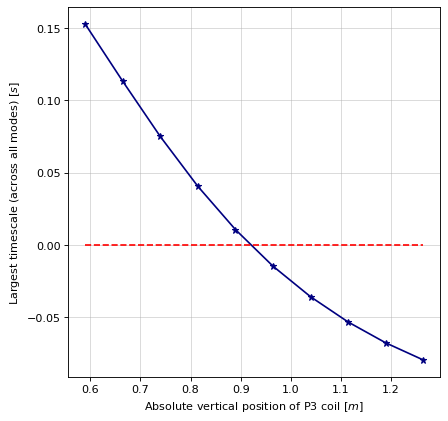

In [21]:
# plot largest timescales
max_timescales = [np.max(entry) for entry in timescales]

fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6), dpi=80)
ax1.grid(zorder=0, alpha=0.5)
plt.plot(abs_P3_position, max_timescales, 'navy', marker='*')
plt.hlines(xmin=min(abs_P3_position), xmax=max(abs_P3_position), y=0.0, linestyle='--', color='r')
# ax1.set_aspect('equal')
ax1.set_xlabel(r'Absolute vertical position of P3 coil $[m]$')
ax1.set_ylabel(r'Largest timescale (across all modes) $[s]$')
# ax1.set_yscale('log')
plt.show()

Here we plot a few of the equilibria as the coils are moved.

(-1.5, 1.5)

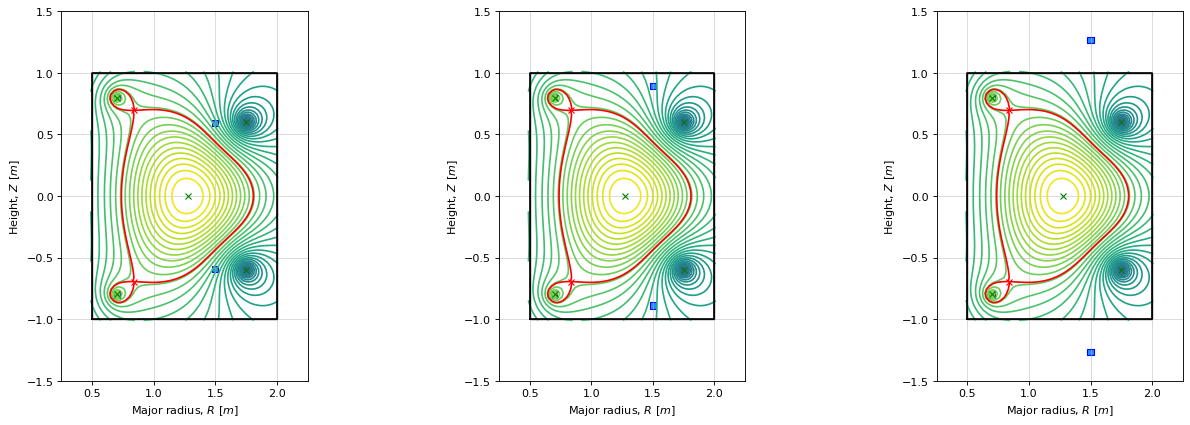

In [22]:
# which indices to plot
idx1 = 0
idx2 = 4
idx3 = 9

# plot equilbiria
fig1, ax = plt.subplots(1, 3, figsize=(20, 6), dpi=80)

ax[0].grid(zorder=0, alpha=0.5)
eqs[idx1].plot(axis=ax[0],show=False)
eqs[idx1].tokamak.plot(axis=ax[0], show=False)
ax[0].fill(eqs[idx1].tokamak.wall.R, eqs[idx1].tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax[0].set_aspect('equal')
ax[0].set_xlabel(r'Major radius, $R$ $[m]$')
ax[0].set_ylabel(r'Height, $Z$ $[m]$')
ax[0].set_xlim([0.25, 2.25])
ax[0].set_ylim([-1.5, 1.5])

ax[1].grid(zorder=0, alpha=0.5)
eqs[idx2].plot(axis=ax[1],show=False)
eqs[idx2].tokamak.plot(axis=ax[1], show=False)
ax[1].fill(eqs[idx2].tokamak.wall.R, eqs[idx2].tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax[1].set_aspect('equal')
ax[1].set_xlabel(r'Major radius, $R$ $[m]$')
ax[1].set_ylabel(r'Height, $Z$ $[m]$')
ax[1].set_xlim([0.25, 2.25])
ax[1].set_ylim([-1.5, 1.5])

ax[2].grid(zorder=0, alpha=0.5)
eqs[idx3].plot(axis=ax[2],show=False)
eqs[idx3].tokamak.plot(axis=ax[2], show=False)
ax[2].fill(eqs[idx3].tokamak.wall.R, eqs[idx3].tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax[2].set_aspect('equal')
ax[2].set_xlabel(r'Major radius, $R$ $[m]$')
ax[2].set_ylabel(r'Height, $Z$ $[m]$')
ax[2].set_xlim([0.25, 2.25])
ax[2].set_ylim([-1.5, 1.5])

One could repeat this exercise keeping the coil positions fixed but varying a coil current. 